<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/A_Tale_of_Two_Circuits_Grokking_as_Competition_of_Sparse_and_Dense_Subnetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

import random
import numpy as np

import itertools

def parity(n, k, n_samples, seed=42):
    'Data generation'

    random.seed(seed)
    samples = torch.Tensor([[random.choice([-1, 1]) for j in range(n)] for i in range(n_samples)])
    # targets = torch.prod(input[:, n//2:n//2+k], dim=1) # parity hidden in the middle
    targets = torch.prod(samples[:, :k], dim=1) # parity hidden in first k bits

    return samples, targets

@torch.no_grad()
def get_sensitivity(predict_fn, inputs, argmax: bool = True):
    """Get sensitivity of predict_fn on inputs.

    Returns normalized value in [0, 1], where 0 means no sensitivity, and 1 means sensitivity of n_features.

    Args:
        predict_fn: Function to evaluate.
        inputs: Boolean tensor of shape [n_samples, n_features]
        argmax: Reduce output of model_fn on the final axis by taking argmax (for logits).
    """
    _, n_features = inputs.size()
    index = torch.arange(n_features)
    n_flipped = 0
    n_total = 0
    for sample in inputs:
        source = predict_fn(sample)
        batch = sample.repeat(n_features, 1)
        batch[index, index] = -batch[index, index]
        neighbors = predict_fn(batch)
        if argmax:
            source = source.sign()
            neighbors = neighbors.sign()
        n_flipped += (neighbors != source).sum().item()
        n_total += len(neighbors)
    return n_flipped / n_total

def sensitivity_calc(data, model, mask_idx, device='cuda', args=None):
    model.eval()

    if (mask_idx is not None):
        # create mask
        idx = torch.LongTensor([mask_idx for _ in range(data.shape[1])])
        mask = torch.zeros(data.shape[1], args.width)
        mask.scatter_(1, idx, 1.)

        predict_fn = lambda x: model.masked_forward(x, mask.to(device))
    else:
        predict_fn = lambda x: model(x)

    return args.n * get_sensitivity(predict_fn, data.to(device))


def mean_and_std_across_seeds(list_stats):
    array_stats = np.array(list_stats)
    mean = np.average(array_stats, axis=0)
    std =  np.std(array_stats, axis=0)

    return mean, std

def acc_calc(dataloader, model, mask_idx=None, device='cuda', args=None, faithfulness=False):
    model.eval()

    acc, total = 0, 0
    for id, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        if (mask_idx is not None):
            # create mask
            idx = torch.LongTensor([mask_idx for _ in range(len(y_batch))])
            mask = torch.zeros(len(y_batch), args.width)
            mask.scatter_(1, idx, 1.)

            pred = model.masked_forward(x_batch, mask.to(device))
            if (faithfulness):
                fullmodel_pred = model(x_batch)
        else:
            pred = model(x_batch)
        if (faithfulness):
            acc += (torch.sign(torch.squeeze(pred)) == torch.sign(torch.squeeze(fullmodel_pred))).sum().item()
        else:
            acc += (torch.sign(torch.squeeze(pred)) == y_batch).sum().item()
        total += x_batch.shape[0]

    return acc / total


def loss_calc(dataloader, model, loss_fn, device='cuda'):
    model.eval()

    loss, total = 0, 0
    for id, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        pred = model(x_batch)
        loss += loss_fn(pred, y_batch).sum().item()
        total += x_batch.shape[0]

    return loss / total

def circuit_discovery_linear(epoch, saved_model, norms, dataloader, device='cuda', args=None):
    # Calculate least number of neurons that recovers original (train set) performance with linear search

    values = np.array(norms['feats'][epoch]).argsort()
    for k in range(1, args.width):
        idx = values[-k:]
        masked_acc = acc_calc(dataloader, saved_model, idx, device=device, args=args)
        full_acc = acc_calc(dataloader, saved_model, device=device, args=args)

        if (masked_acc == full_acc):
            return k, idx

    return float('inf'), None # mistake


def circuit_discovery_binary(epoch, saved_model, norms, dataloader, device='cuda', args=None):
    # Calculate least number of neurons that recovers original (train set) performance with binary search (assuming that it increases monotonically)

    left, right = 1, args.width
    prev_k = -1
    min_k, min_idx = float('inf'), None

    values = np.array(norms['feats'][epoch]).argsort()
    while left < right:
        k = (left + right) // 2
        if (prev_k == k):
            break

        idx = values[-k:]
        masked_acc = acc_calc(dataloader, saved_model, idx, device=device, args=args)
        full_acc = acc_calc(dataloader, saved_model, device=device, args=args)

        if (masked_acc == full_acc) and (k < min_k):
            min_k = k
            min_idx = idx
        if (masked_acc < full_acc):
            left = k
        else:
            right = k + 1

        prev_k = k

    return min_k, min_idx

class FF1(torch.nn.Module):
    def __init__(self, input_dim=40, width=1000):
        super(FF1, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, width)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(width, 1, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

    def masked_forward(self, x, mask):
        x = self.linear1(x)
        x = self.activation(x)
        x = x * mask
        x = self.linear2(x)
        return x

class MyHingeLoss(torch.nn.Module):
    def __init__(self):
        super(MyHingeLoss, self).__init__()

    def forward(self, output, target):
        hinge_loss = 1 - torch.mul(torch.squeeze(output), torch.squeeze(target))
        hinge_loss[hinge_loss < 0] = 0
        return hinge_loss

class ArityFinder:
    def __init__(self, model, inputs):
        self.model = model
        self.inputs = inputs
        self.predictions = self.predict()

    def predict(self):
        return self.model(self.inputs).sign()

    @torch.no_grad()
    def get_active_inputs(self, key: str = "linear1") -> list:
        self.linear = self.model.get_submodule(key)
        arange = torch.arange(self.linear.weight.size(1)).to('cuda')
        all_active = []
        for neuron, weights in enumerate(self.linear.weight):
            self.neuron = neuron
            self.old_weights = weights.data.clone()
            self.indices = weights.abs().argsort()
            n_pruned = self.get_n_pruned(0, len(weights))
            active = arange[self.indices >= n_pruned]
            all_active.append(active.tolist())

        return all_active

    @torch.no_grad()
    def get_arities(self, key: str = "linear1") -> list:
        self.linear = self.model.get_submodule(key)
        arities = []
        for neuron, weights in enumerate(self.linear.weight):
            self.neuron = neuron
            self.old_weights = weights.data.clone()
            self.indices = weights.abs().argsort()
            n_pruned = self.get_n_pruned(0, len(weights))
            arities.append(len(weights) - n_pruned)
        return arities

    def get_n_pruned(self, floor, ceil) -> int:
        """Get the arity of self.neuron.

        Args:
            floor: Number we know we can prune.
            ceil: Number we could possibly prune.

        # TODO: Could possibly simplify base case.
        """
        if floor == ceil:
            return floor
        # elif floor == ceil - 1:
        #     mask = (self.indices >= ceil)
        #     self.linear.weight.data[self.neuron] *= mask
        #     predictions = self.predict()
        #     self.linear.weight.data[self.neuron] = self.old_weights
        #     if (predictions == self.predictions).all():
        #         return ceil
        #     else:
        #         return floor

        midpoint = (floor + ceil + 1) // 2
        mask = (self.indices >= midpoint)
        self.linear.weight.data[self.neuron] *= mask
        predictions = self.predict()
        self.linear.weight.data[self.neuron] = self.old_weights
        if (predictions == self.predictions).all():
            return self.get_n_pruned(midpoint, ceil)
        else:
            return self.get_n_pruned(floor, midpoint - 1)

Epoch 1
-------------------------------
Saving memorizing model - epoch 34
Epoch 101
-------------------------------
Epoch 201
-------------------------------
Saving (final) generalizing model - epoch 299
Epoch 1
-------------------------------
Saving memorizing model - epoch 25
Epoch 101
-------------------------------
Epoch 201
-------------------------------
Saving (final) generalizing model - epoch 299
Epoch 1
-------------------------------
Saving memorizing model - epoch 32
Epoch 101
-------------------------------
Epoch 201
-------------------------------
Saving (final) generalizing model - epoch 299
Epoch 1
-------------------------------
Saving memorizing model - epoch 30
Epoch 101
-------------------------------
Epoch 201
-------------------------------
Saving (final) generalizing model - epoch 299
Epoch 1
-------------------------------
Saving memorizing model - epoch 28
Epoch 101
-------------------------------
Epoch 201
-------------------------------
Saving (final) genera

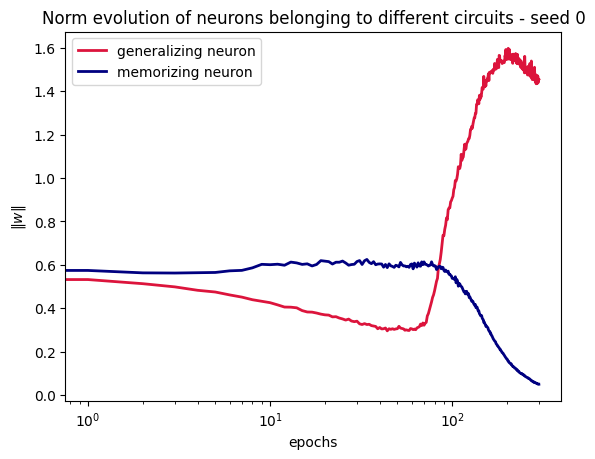

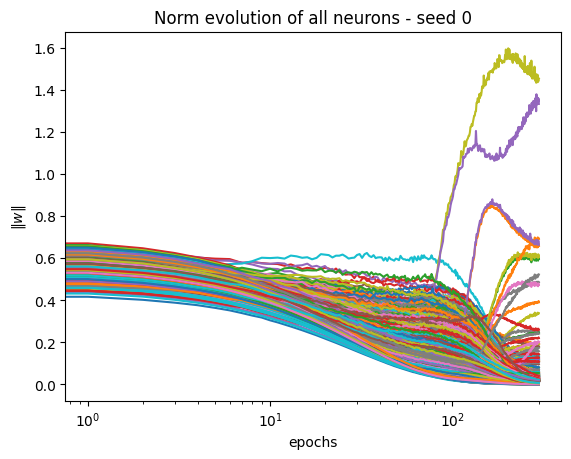

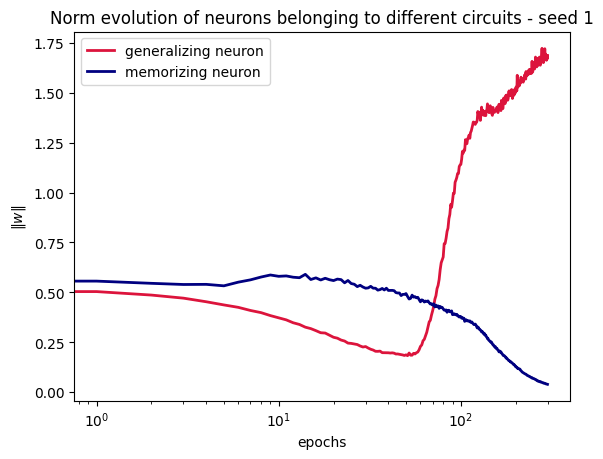

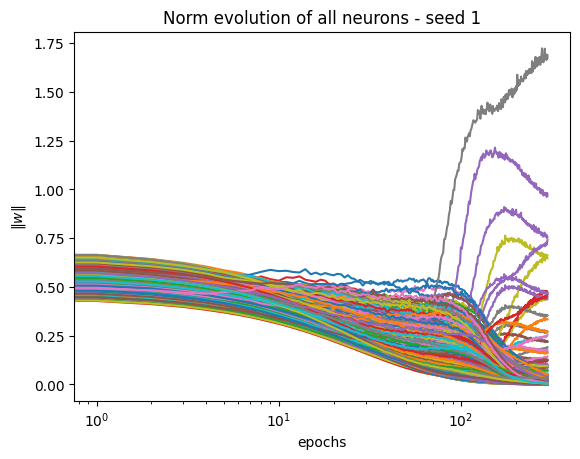

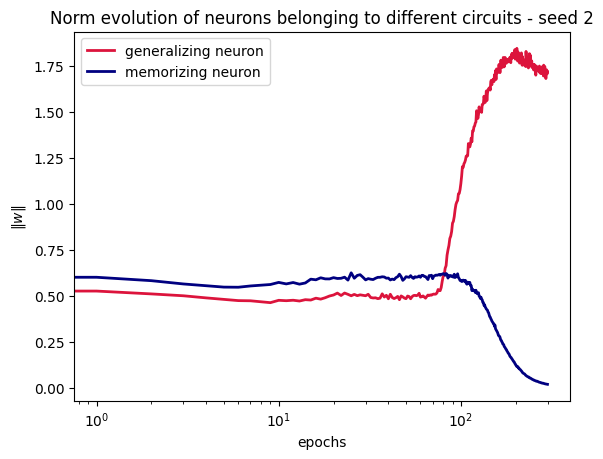

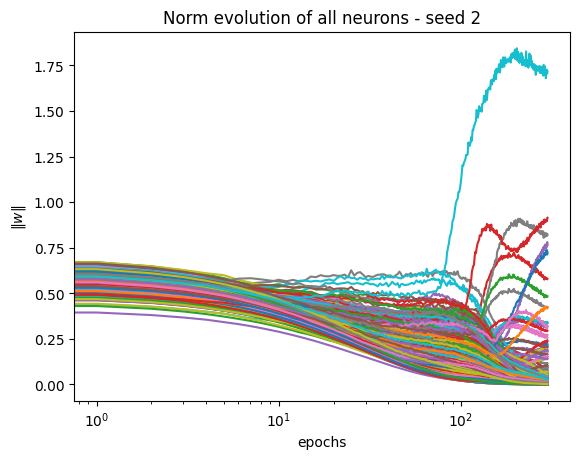

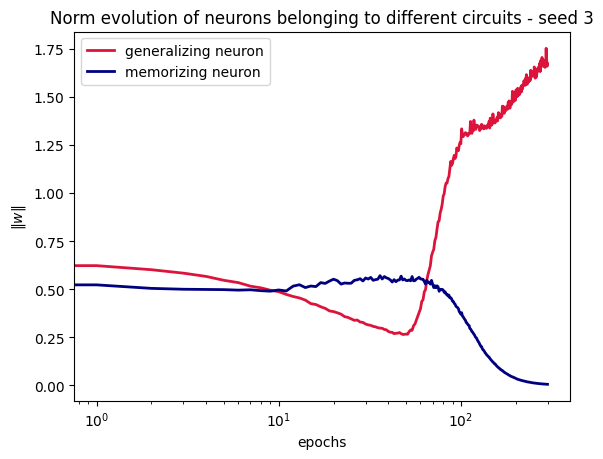

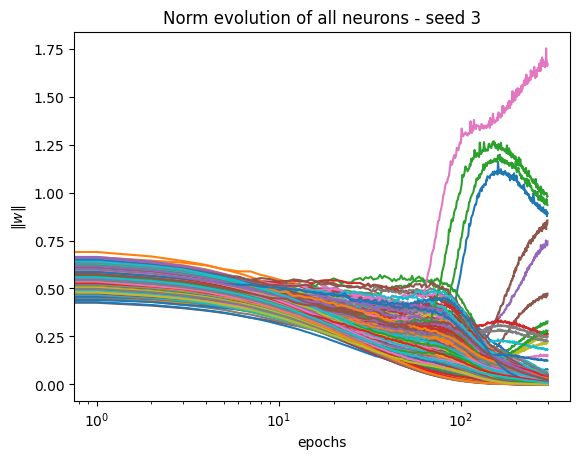

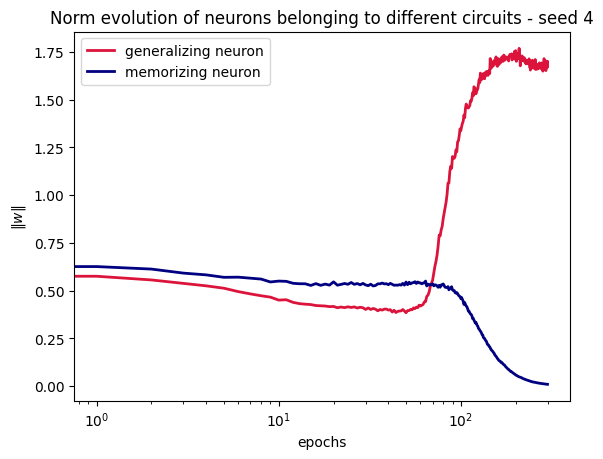

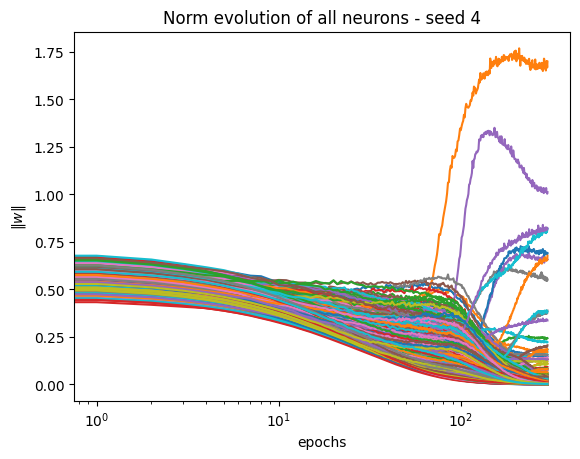

<ipython-input-3-baba7d9a62c7>:239: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _model.load_state_dict(torch.load(os.path.join(path, f'model_{epoch}.pt')))
<ipython-input-

Memorizing circuit has size equal to 583 with neurons [633 899 425 107 938 819 378 279 953 601 545  62 650 230  98 140 750 714
 343 350 710 701 400  17 709  65 517  66 771 316  60 479 152 187 964 816
 192 447 540 623 526 558 987  43  82 238 822 616 308 129 917 331 935 918
 110 853 395  73 546 520 274  37 166 925  69 631 647 995 665 570 919 941
 790 500 318  71 353  78 448 438 124 513 673  86  92 760 113 777 434 707
 141  95 979 911 945 472 280 283  84 676 155 103 961  57 937 557  72 416
 732 654 693 638 892 522 591  42 297 322 550 521 519 330 920 451 408 108
 737 575 249 392 692 460 908 111 126  31 130 944 396 257 498 909 309 872
 163  48   2  76 578 565 880 747 534 459 653 912 833 969 907 687 483 502
 789 524 963 806 967  28 664 891 831  35 960 854 649 329  53 493 231 615
 273 815 478 398  40 291 441 835 972  59  96 741 475 678 501 218 924 943
  56 997 876 115 362 940 629 627 259 684 652 586 993 894 393  93 754  67
 181 391 635 548 630 888 881 382 893 473  38 877 998 588 323 320 761 4

<ipython-input-3-baba7d9a62c7>:281: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load(os.path.join(path, f'generalization.pt')))


Generalizing (final) circuit has size equal to 9 with neurons [227 987 152 578 151 944 741 504 268]


<ipython-input-3-baba7d9a62c7>:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _model.load_state_dict(torch.load(os.path.join(path, f'model_{epoch}.pt')))


Memorizing circuit has size equal to 913 with neurons [955 537 144 582 244 312  68 862 702 555 484 148 692 435 232 876 151 701
 939 237 891 874 699 421 881 114 743 839 295  98 197 919  99 497   0 647
 740 474 415 928 527 480 119 609 911 520 855 748  78 557 837 678 840 133
 243 428 790 396 381 530 607 708 223 227 744 571 308 259 341 159 338 700
 352 666 651 252 124  30  29 782 473 998 309 764  47 597   2 470 936 162
 175 592 604 326  48 877 608 191 573 703 974 901 783 965 898 667 328 105
  50 972 387 263 486 391 431 198  75 830 605 650 857 409 273 239 619 246
 953 688 742 763 722  21 648 303 543 791  45 194 568 693 233 641 823 180
 677 251  59 514 905  81 768 920 538 903 173 927 299 658 591 904 360 781
 906 944 895 511 780 570 241 576 601 313 426 732 863 921 832 100  43 306
 962 971 406 121 645 302 261 634 585  86 856 984 815 430 278 683 154 388
 289 985 472 495 961 200  74 339 323 255 230 662 138 270 155  42 460 414
 446  61 564 335 515 279 327 283 562 236 940 286 216 563 802 566 642  

In [ ]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np
# from utils import *

# 直接設定値を定義
class Args:
    n = 40
    k = 3
    N = 1000
    B = 32
    epochs = 300
    lr = 0.1
    weight_decay = 0.01
    width = 1000
    n_seeds = 5
    train = True
    ind_norms = True
    global_sparsity = True
    subnetworks = True
    sparsity_sampling = 10
    faithfulness = True
    lottery_ticket = True

args = Args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def data_preparation(args, seed_id=42, test_samples=100, test_batchsize=100, return_raw=False):
    # Data generation - different seed each time
    _data = parity(args.n, args.k, args.N, seed=seed_id*17)
    train_dataset = TensorDataset(_data[0], _data[1])
    train_dataloader = DataLoader(train_dataset, batch_size=args.B, shuffle=True)

    data = parity(args.n, args.k, test_samples, seed=2001) # constant test samples
    test_dataset = TensorDataset(data[0], data[1])
    test_dataloader = DataLoader(test_dataset, batch_size=test_batchsize, shuffle=True)

    if (return_raw):
        return train_dataloader, train_dataloader, _data[0][:100], data[0]
    return train_dataloader, test_dataloader

def main():
    loss_fn = MyHingeLoss()

    base_dir = f'./results/n_{args.n}/k_{args.k}/N_{args.N}/lr_{args.lr}/wd_{args.weight_decay}/width_{args.width}'
    os.makedirs(base_dir, exist_ok=True)

    fig_path = os.path.join(base_dir, 'figures')
    os.makedirs(fig_path, exist_ok=True)

    losses, accs, normss = {'train': [], 'test': []}, {'train': [], 'test': []}, []
    mem_epochs, gen_epochs = [], []

    if args.train:
        for seed_id in range(args.n_seeds):
            torch.manual_seed(seed_id)

            # Data & save_dir preparation
            train_dataloader, test_dataloader = data_preparation(args, seed_id)
            path = os.path.join(base_dir, f'seed{seed_id}_checkpoints')
            os.makedirs(path, exist_ok=True)

            # Model & Optim initialization
            model = FF1(input_dim=args.n, width=args.width)
            model = model.to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

            mem_epochs.append(-1)
            gen_epochs.append(-1)
            train_loss, test_loss = [], []
            train_acc, test_acc = [], []
            norms = {'feats':  [],
                    'conx':  []}
            for epoch in range(args.epochs):
                if (epoch % 100 == 0):
                    print(f"Epoch {epoch + 1}\n-------------------------------")

                # Norm statistics
                norms['feats'].append(torch.linalg.norm(list(model.parameters())[0], dim=1).detach().cpu().numpy())
                norms['conx'].append(torch.squeeze(list(model.parameters())[2]).detach().cpu().numpy())

                # Loss & Accuracy statistics
                train_loss.append(loss_calc(train_dataloader, model, loss_fn))
                test_loss.append(loss_calc(test_dataloader, model, loss_fn))

                train_acc.append(acc_calc(train_dataloader, model))
                test_acc.append(acc_calc(test_dataloader, model))

                # Save memorizing / generalizing network
                if (train_acc[-1] > 0.98 and mem_epochs[-1] < 0):
                    print(f'Saving memorizing model - epoch {epoch}')
                    torch.save(model.state_dict(), os.path.join(path, 'memorization.pt'))
                    mem_epochs[-1] = epoch
                # if (test_acc[-1] > 0.98 and gen_epochs[-1] < 0):
                #     print(f'Saving initially generalizing model - epoch {epoch}')
                #     torch.save(model.state_dict(), os.path.join(path, 'initial_generalization.pt'))
                if (epoch == args.epochs - 1):
                    print(f'Saving (final) generalizing model - epoch {epoch}')
                    torch.save(model.state_dict(), os.path.join(path, 'generalization.pt'))
                    gen_epochs[-1] = epoch

                # Save model
                torch.save(model.state_dict(), os.path.join(path, f'model_{epoch}.pt'))
                # Train model
                for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    pred = model(x_batch)

                    optimizer.zero_grad()
                    loss = loss_fn(pred, y_batch).mean()
                    loss.backward()
                    optimizer.step()

            losses['train'].append(train_loss)
            losses['test'].append(test_loss)

            accs['train'].append(train_acc)
            accs['test'].append(test_acc)

            normss.append(norms)


        # Save files
        with open(os.path.join(base_dir, 'normss'), "wb") as fp:
            pickle.dump(normss, fp)

        with open(os.path.join(base_dir, 'mem_epochs'), "wb") as fp:
            pickle.dump(mem_epochs, fp)

        with open(os.path.join(base_dir, 'gen_epochs'), "wb") as fp:
            pickle.dump(gen_epochs, fp)

        # Save and Plot train (test) curves (acc & loss)
        m1, std1 = mean_and_std_across_seeds(losses['train'])
        np.save(os.path.join(base_dir, 'mean_train_loss'), m1)
        np.save(os.path.join(base_dir, 'std_train_loss'), std1)

        m2, std2 = mean_and_std_across_seeds(losses['test'])
        np.save(os.path.join(base_dir, 'mean_test_loss'), m2)
        np.save(os.path.join(base_dir, 'std_test_loss'), std2)

        m3, std3 = mean_and_std_across_seeds(accs['train'])
        np.save(os.path.join(base_dir, 'mean_train_acc'), m3)
        np.save(os.path.join(base_dir, 'std_train_acc'), std3)

        m4, std4 = mean_and_std_across_seeds(accs['test'])
        np.save(os.path.join(base_dir, 'mean_test_acc'), m4)
        np.save(os.path.join(base_dir, 'std_test_acc'), std4)

        plt.plot(m1, linestyle='-', label='train')
        plt.plot(m2, linestyle='-', label='test')
        plt.fill_between([i for i in range(args.epochs)], m1 - std1, m1 + std1, alpha = 0.3)
        plt.fill_between([i for i in range(args.epochs)], m2 - std2, m2 + std2, alpha = 0.3)
        plt.title('Loss')
        plt.xlabel('epochs')
        plt.xscale('log')
        plt.legend()
        plt.savefig(os.path.join(fig_path, 'loss.pdf'))
        plt.close()

        plt.plot(m3, linestyle='-', label='train')
        plt.plot(m4, linestyle='-', label='test')
        plt.fill_between([i for i in range(args.epochs)], m3 - std3, m3 + std3, alpha = 0.3)
        plt.fill_between([i for i in range(args.epochs)], m4 - std4, m4 + std4, alpha = 0.3)
        plt.title('Accuracy')
        plt.xlabel('epochs')
        plt.xscale('log')
        plt.legend()
        plt.savefig(os.path.join(fig_path, 'acc.pdf'))
        plt.close()

    else:
        with open(os.path.join(base_dir, 'normss'), "rb") as fp:
            normss = pickle.load(fp)

        with open(os.path.join(base_dir, 'mem_epochs'), "rb") as fp:
            mem_epochs = pickle.load(fp)

        with open(os.path.join(base_dir, 'gen_epochs'), "rb") as fp:
            gen_epochs = pickle.load(fp)


    if args.ind_norms:
        # Show norm evolutions
        for seed_id in range(args.n_seeds):
            best = normss[seed_id]['feats'][gen_epochs[seed_id]].argmax()
            prev_best = normss[seed_id]['feats'][mem_epochs[seed_id]].argmax()

            traj, prev_traj = [], []
            for k in range(args.epochs):
                traj.append(normss[seed_id]['feats'][k][best])
                prev_traj.append(normss[seed_id]['feats'][k][prev_best])

            plt.plot(traj, label='generalizing neuron', lw=2, color='crimson')
            plt.plot(prev_traj, label='memorizing neuron', lw=2, color='navy')
            plt.title(f'Norm evolution of neurons belonging to different circuits - seed {seed_id}')
            plt.xscale('log')
            plt.xlabel('epochs')
            plt.ylabel(r'$\| w \|$')
            plt.legend()
            plt.savefig(os.path.join(fig_path, f'norm_contrast_seed{seed_id}.pdf'))
            plt.show()
            plt.close()

            trajs = []
            for neuron in range(args.width):
                trajs.append([])
                for k in range(args.epochs):
                    trajs[-1].append(normss[seed_id]['feats'][k][neuron])

            for neuron in range(args.width):
                plt.plot(trajs[neuron])
            plt.title(f'Norm evolution of all neurons - seed {seed_id}')
            plt.xlabel('epochs')
            plt.ylabel(r'$\| w \|$')
            plt.xscale('log')
            plt.savefig(os.path.join(fig_path, f'all_neurons_norm_seed{seed_id}.pdf'))
            plt.show()
            plt.close()


    if args.global_sparsity:
        # Global sparsity over time
        sparsities = []
        for seed_id in range(args.n_seeds):
            sparsity = []
            path = os.path.join(base_dir, f'seed{seed_id}_checkpoints')
            train_dataloader, _ = data_preparation(args, seed_id) # load the training dataset of that seed_id
            for epoch in range(0, args.epochs, args.sparsity_sampling):
                _model = FF1(input_dim=args.n, width=args.width).to(device)
                _model.load_state_dict(torch.load(os.path.join(path, f'model_{epoch}.pt')))
                if (epoch < 20):
                    # warm up for irregular behavior in the beginning - non monotonic accuracy (pruning helps apparently?)
                    size, _ = circuit_discovery_linear(epoch, _model, normss[seed_id], train_dataloader, device, args=args)
                else:
                    size, _ = circuit_discovery_binary(epoch, _model, normss[seed_id], train_dataloader, device, args=args)
                    if (size == float('inf')):
                        # binary search failed?!
                        size, _ = circuit_discovery_linear(epoch, _model, normss[seed_id], train_dataloader, device, args=args)

                sparsity.append(size)
            sparsities.append(sparsity)

        mean_sparsity, std_sparsity = mean_and_std_across_seeds(sparsities)
        np.save(os.path.join(base_dir, 'mean_sparsity_over_time'), mean_sparsity)
        np.save(os.path.join(base_dir, 'std_sparsity_over_time'), std_sparsity)

        plt.plot([i for i in range(0, args.epochs, args.sparsity_sampling)], mean_sparsity, linestyle='-')
        plt.fill_between([i for i in range(0, args.epochs, args.sparsity_sampling)], mean_sparsity - std_sparsity, mean_sparsity + std_sparsity, alpha = 0.3)
        plt.title('Sparsity of network')
        plt.xlabel('epochs')
        plt.ylabel('#neurons')
        plt.xscale('log')
        plt.savefig(os.path.join(fig_path, 'sparsity.pdf'))
        plt.close()


    if args.subnetworks:
        # Subnetworks calculations & reconstruction accuracy
        mem_accs, gen_accs, mem_but_gen_accs, all_but_gen_accs, control_accs = {'train': [], 'test': []}, {'train': [], 'test': []}, {'train': [], 'test': []}, {'train': [], 'test': []}, {'train': [], 'test': []}
        mem_sens, gen_sens, mem_but_gen_sens, all_but_gen_sens, control_sens = {'train': [], 'test': []}, {'train': [], 'test': []}, {'train': [], 'test': []}, {'train': [], 'test': []}, {'train': [], 'test': []}
        mem_norms, gen_norms, mem_but_gen_norms, all_but_gen_norms, control_norms = [], [], [], [], []
        for seed_id in range(args.n_seeds):
            path = os.path.join(base_dir, f'seed{seed_id}_checkpoints')
            train_dataloader, test_dataloader, train_samples, test_samples = data_preparation(args, seed_id, return_raw=True) # load the training dataset of that seed_id

            mem_model = FF1(input_dim=args.n, width=args.width).to(device)
            mem_model.load_state_dict(torch.load(os.path.join(path, f'memorization.pt')))
            mem_size, mem_idx = circuit_discovery_linear(mem_epochs[seed_id], mem_model, normss[seed_id], train_dataloader, device, args=args)
            print(f'Memorizing circuit has size equal to {mem_size} with neurons {mem_idx}')

            gen_model = FF1(input_dim=args.n, width=args.width).to(device)
            gen_model.load_state_dict(torch.load(os.path.join(path, f'generalization.pt')))
            gen_size, gen_idx = circuit_discovery_linear(gen_epochs[seed_id], gen_model, normss[seed_id], train_dataloader, device, args=args)
            print(f'Generalizing (final) circuit has size equal to {gen_size} with neurons {gen_idx}')

            mem_but_gen_idx = list(set(mem_idx) - set(gen_idx))
            all_but_gen_idx = list(set([i for i in range(args.width)]) - set(gen_idx))

            random.seed(seed_id)
            control_idx = random.sample(range(args.width), k=gen_size)

            mem_train_acc, mem_test_acc, gen_train_acc, gen_test_acc, mem_but_gen_train_acc, mem_but_gen_test_acc , all_but_gen_train_acc, all_but_gen_test_acc, control_train_acc, control_test_acc = [], [], [], [], [], [], [], [], [], []
            mem_train_sens, mem_test_sens, gen_train_sens, gen_test_sens, mem_but_gen_train_sens, mem_but_gen_test_sens , all_but_gen_train_sens, all_but_gen_test_sens, control_train_sens, control_test_sens = [], [], [], [], [], [], [], [], [], []
            mem_norm, gen_norm, mem_but_gen_norm, all_but_gen_norm, control_norm = [], [], [], [], []
            # masked inference for the different sets of indices
            for epoch in range(args.epochs):
                _model = FF1(input_dim=args.n, width=args.width).to(device)
                _model.load_state_dict(torch.load(os.path.join(path, f'model_{epoch}.pt')))
                neurons = list(_model.parameters())[0]

                gen_train_acc.append(acc_calc(train_dataloader, _model, gen_idx, device=device, args=args, faithfulness=args.faithfulness))
                gen_test_acc.append(acc_calc(test_dataloader, _model, gen_idx, device=device, args=args, faithfulness=args.faithfulness))
                gen_norm.append(torch.linalg.norm(neurons[gen_idx], dim=1).detach().cpu().numpy().mean())
                gen_train_sens.append(sensitivity_calc(train_samples, _model, gen_idx, device=device, args=args))
                gen_test_sens.append(sensitivity_calc(test_samples, _model, gen_idx, device=device, args=args))

                all_but_gen_train_acc.append(acc_calc(train_dataloader, _model, all_but_gen_idx, device=device, args=args, faithfulness=args.faithfulness))
                all_but_gen_test_acc.append(acc_calc(test_dataloader, _model, all_but_gen_idx, device=device, args=args, faithfulness=args.faithfulness))
                all_but_gen_norm.append(torch.linalg.norm(neurons[all_but_gen_idx], dim=1).detach().cpu().numpy().mean())
                all_but_gen_train_sens.append(sensitivity_calc(train_samples, _model, all_but_gen_idx, device=device, args=args))
                all_but_gen_test_sens.append(sensitivity_calc(test_samples, _model, all_but_gen_idx, device=device, args=args))

                control_train_acc.append(acc_calc(train_dataloader, _model, control_idx, device=device, args=args, faithfulness=args.faithfulness))
                control_test_acc.append(acc_calc(test_dataloader, _model, control_idx, device=device, args=args, faithfulness=args.faithfulness))
                control_norm.append(torch.linalg.norm(neurons[control_idx], dim=1).detach().cpu().numpy().mean())
                control_train_sens.append(sensitivity_calc(train_samples, _model, control_idx, device=device, args=args))
                control_test_sens.append(sensitivity_calc(test_samples, _model, control_idx, device=device, args=args))


            gen_accs['train'].append(gen_train_acc)
            gen_accs['test'].append(gen_test_acc)
            gen_norms.append(gen_norm)
            gen_sens['train'].append(gen_train_sens)
            gen_sens['test'].append(gen_test_sens)

            all_but_gen_accs['train'].append(all_but_gen_train_acc)
            all_but_gen_accs['test'].append(all_but_gen_test_acc)
            all_but_gen_norms.append(all_but_gen_norm)
            all_but_gen_sens['train'].append(all_but_gen_train_sens)
            all_but_gen_sens['test'].append(all_but_gen_test_sens)

            control_accs['train'].append(control_train_acc)
            control_accs['test'].append(control_test_acc)
            control_norms.append(control_norm)
            control_sens['train'].append(control_train_sens)
            control_sens['test'].append(control_test_sens)


        mean_gen_train_acc, std_gen_train_acc = mean_and_std_across_seeds(gen_accs['train'])
        np.save(os.path.join(base_dir, 'mean_gen_train_faith'), mean_gen_train_acc)
        np.save(os.path.join(base_dir, 'std_gen_train_faith'), std_gen_train_acc)

        mean_gen_test_acc, std_gen_test_acc = mean_and_std_across_seeds(gen_accs['test'])
        np.save(os.path.join(base_dir, 'mean_gen_test_faith'), mean_gen_test_acc)
        np.save(os.path.join(base_dir, 'std_gen_test_faith'), std_gen_test_acc)

        mean_all_but_gen_train_acc, std_all_but_gen_train_acc = mean_and_std_across_seeds(all_but_gen_accs['train'])
        np.save(os.path.join(base_dir, 'mean_all_but_gen_train_faith'), mean_all_but_gen_train_acc)
        np.save(os.path.join(base_dir, 'std_all_but_gen_train_faith'), std_all_but_gen_train_acc)

        mean_all_but_gen_test_acc, std_all_but_gen_test_acc = mean_and_std_across_seeds(all_but_gen_accs['test'])
        np.save(os.path.join(base_dir, 'mean_all_but_gen_test_faith'), mean_all_but_gen_test_acc)
        np.save(os.path.join(base_dir, 'std_all_but_gen_test_faith'), std_all_but_gen_test_acc)

        mean_control_train_acc, std_control_train_acc = mean_and_std_across_seeds(control_accs['train'])
        np.save(os.path.join(base_dir, 'mean_control_train_faith'), mean_control_train_acc)
        np.save(os.path.join(base_dir, 'std_control_train_faith'), std_control_train_acc)

        mean_control_test_acc, std_control_test_acc = mean_and_std_across_seeds(control_accs['test'])
        np.save(os.path.join(base_dir, 'mean_control_test_faith'), mean_control_test_acc)
        np.save(os.path.join(base_dir, 'std_control_test_faith'), std_control_test_acc)

        # norms

        mean_gen_norm, std_gen_norm = mean_and_std_across_seeds(gen_norms)
        np.save(os.path.join(base_dir, 'mean_gen_norm'), mean_gen_norm)
        np.save(os.path.join(base_dir, 'std_gen_norm'), std_gen_norm)

        mean_all_but_gen_norm, std_all_but_gen_norm = mean_and_std_across_seeds(all_but_gen_norms)
        np.save(os.path.join(base_dir, 'mean_all_but_gen_norm'), mean_all_but_gen_norm)
        np.save(os.path.join(base_dir, 'std_all_but_gen_norm'), std_all_but_gen_norm)

        mean_control_norm, std_control_norm = mean_and_std_across_seeds(control_norms)
        np.save(os.path.join(base_dir, 'mean_control_norm'), mean_control_norm)
        np.save(os.path.join(base_dir, 'std_control_norm'), std_control_norm)

        # sensitivity

        mean_gen_train_sens, std_gen_train_sens = mean_and_std_across_seeds(gen_sens['train'])
        np.save(os.path.join(base_dir, 'mean_gen_train_sens'), mean_gen_train_sens)
        np.save(os.path.join(base_dir, 'std_gen_train_sens'), std_gen_train_sens)

        mean_gen_test_sens, std_gen_test_sens = mean_and_std_across_seeds(gen_sens['test'])
        np.save(os.path.join(base_dir, 'mean_gen_test_sens'), mean_gen_test_sens)
        np.save(os.path.join(base_dir, 'std_gen_test_sens'), std_gen_test_sens)

        mean_all_but_gen_train_sens, std_all_but_gen_train_sens = mean_and_std_across_seeds(all_but_gen_sens['train'])
        np.save(os.path.join(base_dir, 'mean_all_but_gen_train_sens'), mean_all_but_gen_train_sens)
        np.save(os.path.join(base_dir, 'std_all_but_gen_train_sens'), std_all_but_gen_train_sens)

        mean_all_but_gen_test_sens, std_all_but_gen_test_sens = mean_and_std_across_seeds(all_but_gen_sens['test'])
        np.save(os.path.join(base_dir, 'mean_all_but_gen_test_sens'), mean_all_but_gen_test_sens)
        np.save(os.path.join(base_dir, 'std_all_but_gen_test_sens'), std_all_but_gen_test_sens)

        mean_control_train_sens, std_control_train_sens = mean_and_std_across_seeds(control_sens['train'])
        np.save(os.path.join(base_dir, 'mean_control_train_sens'), mean_control_train_sens)
        np.save(os.path.join(base_dir, 'std_control_train_sens'), std_control_train_sens)

        mean_control_test_sens, std_control_test_sens = mean_and_std_across_seeds(control_sens['test'])
        np.save(os.path.join(base_dir, 'mean_control_test_sens'), mean_control_test_sens)
        np.save(os.path.join(base_dir, 'std_control_test_sens'), std_control_test_sens)


    if args.lottery_ticket:
        for seed_id in range(args.n_seeds):
            path = os.path.join(base_dir, f'seed{seed_id}_checkpoints')
            train_dataloader, test_dataloader = data_preparation(args, seed_id) # load the training dataset of that seed_id

            gen_model = FF1(input_dim=args.n, width=args.width).to(device)
            gen_model.load_state_dict(torch.load(os.path.join(path, f'generalization.pt')))
            gen_size, gen_idx = circuit_discovery_linear(gen_epochs[seed_id], gen_model, normss[seed_id], train_dataloader, device, args=args)
            print(f'Generalizing (final) circuit has size equal to {gen_size} with neurons {gen_idx}')

            # Train from scratch this lottery ticket

            torch.manual_seed(seed_id)
            # Model & Optim initialization
            model = FF1(input_dim=args.n, width=gen_size).to(device)
            init_model = FF1(input_dim=args.n, width=args.width).to(device)
            init_model.load_state_dict(torch.load(os.path.join(path, f'model_0.pt')))
            # pass parameters from initial model
            model.linear1.weight = torch.nn.Parameter(init_model.linear1.weight[gen_idx])
            model.linear1.bias = torch.nn.Parameter(init_model.linear1.bias[gen_idx])
            model.linear2.weight = torch.nn.Parameter(init_model.linear2.weight[:, gen_idx])

            optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

            train_loss, test_loss = [], []
            train_acc, test_acc = [], []
            norms = {'feats':  [],
                    'conx':  []}
            for epoch in range(args.epochs):
                if (epoch % 100 == 0):
                    print(f"Epoch {epoch + 1}\n-------------------------------")

                # Norm statistics
                norms['feats'].append(torch.linalg.norm(list(model.parameters())[0], dim=1).detach().cpu().numpy())
                norms['conx'].append(torch.squeeze(list(model.parameters())[2]).detach().cpu().numpy())

                # Loss & Accuracy statistics
                train_loss.append(loss_calc(train_dataloader, model, loss_fn))
                test_loss.append(loss_calc(test_dataloader, model, loss_fn))

                train_acc.append(acc_calc(train_dataloader, model))
                test_acc.append(acc_calc(test_dataloader, model))

                # Save model
                torch.save(model.state_dict(), os.path.join(path, f'lottery_model_{epoch}.pt'))
                # Train model
                for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    pred = model(x_batch)

                    optimizer.zero_grad()
                    loss = loss_fn(pred, y_batch).mean()
                    loss.backward()
                    optimizer.step()

            losses['train'].append(train_loss)
            losses['test'].append(test_loss)

            accs['train'].append(train_acc)
            accs['test'].append(test_acc)

            normss.append(norms)

            # Save and Plot train (test) curves (acc & loss)
            m1, std1 = mean_and_std_across_seeds(losses['train'])
            np.save(os.path.join(base_dir, 'lottery_mean_train_loss'), m1)
            np.save(os.path.join(base_dir, 'lottery_std_train_loss'), std1)

            m2, std2 = mean_and_std_across_seeds(losses['test'])
            np.save(os.path.join(base_dir, 'lottery_mean_test_loss'), m2)
            np.save(os.path.join(base_dir, 'lottery_std_test_loss'), std2)

            m3, std3 = mean_and_std_across_seeds(accs['train'])
            np.save(os.path.join(base_dir, 'lottery_mean_train_acc'), m3)
            np.save(os.path.join(base_dir, 'lottery_std_train_acc'), std3)

            m4, std4 = mean_and_std_across_seeds(accs['test'])
            np.save(os.path.join(base_dir, 'lottery_mean_test_acc'), m4)
            np.save(os.path.join(base_dir, 'lottery_std_test_acc'), std4)

            plt.plot(m1, linestyle='-', label='train')
            plt.plot(m2, linestyle='-', label='test')
            plt.fill_between([i for i in range(args.epochs)], m1 - std1, m1 + std1, alpha = 0.3)
            plt.fill_between([i for i in range(args.epochs)], m2 - std2, m2 + std2, alpha = 0.3)
            plt.title('Loss of Lottery Ticket')
            plt.xlabel('epochs')
            plt.xscale('log')
            plt.legend()
            plt.savefig(os.path.join(fig_path, 'lottery_loss.pdf'))
            plt.close()

            plt.plot(m3, linestyle='-', label='train')
            plt.plot(m4, linestyle='-', label='test')
            plt.fill_between([i for i in range(args.epochs)], m3 - std3, m3 + std3, alpha = 0.3)
            plt.fill_between([i for i in range(args.epochs)], m4 - std4, m4 + std4, alpha = 0.3)
            plt.title('Accuracy of Lottery Ticket')
            plt.xlabel('epochs')
            plt.xscale('log')
            plt.legend()
            plt.savefig(os.path.join(fig_path, 'lottery_acc.pdf'))
            plt.close()

# メイン関数を直接呼び出し
main()